In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

df = pd.read_csv("/content/drive/MyDrive/世界モデル_最終課題 /timeseries.csv")

ID_COL = "patient_id"
TIME_COL = "time_days"

feature_cols = [
    c for c in df.columns
    if c not in [ID_COL, TIME_COL]
    and not c.startswith("met_")
    and not c.startswith("tx_")
]

F = len(feature_cols)
print("num features:", F)

scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

def make_triples(df):
    """
    (x_t, x_{t+1}) でグラフを作って x_{t+2} を予測するためのサンプルを作る
    """
    triples = []
    for pid, g in df.groupby(ID_COL):
        g = g.sort_values(TIME_COL)
        x = g[feature_cols].values
        t = g[TIME_COL].values

        # t, t+1, t+2 が必要なので -2 まで
        for i in range(len(g) - 2):
            triples.append({
                "pid": pid,
                "x_t": x[i],
                "x_tp1": x[i+1],
                "x_tp2": x[i+2],
                "dt01": float(t[i+1] - t[i]),
                "dt12": float(t[i+2] - t[i+1]),
            })
    return triples

triples = make_triples(df)
print("num triples:", len(triples))

for tr in triples:
    tr["x_t"]   = torch.tensor(tr["x_t"],   dtype=torch.float, device=device)
    tr["x_tp1"] = torch.tensor(tr["x_tp1"], dtype=torch.float, device=device)
    tr["x_tp2"] = torch.tensor(tr["x_tp2"], dtype=torch.float, device=device)
    tr["dt01"]  = torch.tensor(tr["dt01"],  dtype=torch.float, device=device)


import torch.nn as nn
import torch.nn.functional as torch_F

class CrossTimeAttention(nn.Module):
    def __init__(self, in_dim, attn_dim):
        super().__init__()
        self.q = nn.Linear(in_dim, attn_dim, bias=False)
        self.k = nn.Linear(in_dim, attn_dim, bias=False)

    def forward(self, x_t, x_tp1):
        """
        x_t, x_tp1: (F, in_dim)
        """
        Q = self.q(x_t)
        K = self.k(x_tp1)
        A = Q @ K.T / np.sqrt(Q.size(-1))
        return torch_F.softmax(A, dim=1)  # row-wise

!pip -q install torch-geometric

from torch_geometric.nn import GCNConv, dense_diff_pool

class DiffPoolItemNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_clusters):
        super().__init__()
        self.gnn_embed = GCNConv(in_dim, hidden_dim)
        self.gnn_pool  = GCNConv(in_dim, num_clusters)

    def forward(self, x, adj):
        # dense adj -> edge_index/edge_weight
        edge_index = adj.nonzero().T
        edge_weight = adj[edge_index[0], edge_index[1]]

        z = self.gnn_embed(x, edge_index, edge_weight)
        s = self.gnn_pool(x, edge_index, edge_weight)

        x_pool, adj_pool, _, _ = dense_diff_pool(
            z.unsqueeze(0),
            adj.unsqueeze(0),
            s.unsqueeze(0)
        )
        return x_pool.squeeze(0), adj_pool.squeeze(0), s

device: cuda
num features: 42
num triples: 123742
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.5 MB/s eta 0:00:00


In [3]:
class ItemGraphEncoder(nn.Module):
    def __init__(self, num_clusters, F_features):
        super().__init__()
        self.F_features = F_features
        self.attn = CrossTimeAttention(1, 16)
        self.diffpool = DiffPoolItemNet(4, 16, num_clusters) # Reduced hidden_dim from 32 to 16
        self.latent_dim = num_clusters * 16   # Adjusted latent_dim accordingly

    def forward(self, triple):
        x_t   = torch.tensor(triple["x_t"],   dtype=torch.float, device=device)
        x_tp1 = torch.tensor(triple["x_tp1"], dtype=torch.float, device=device)
        dt01  = torch.tensor(triple["dt01"],  dtype=torch.float, device=device)

        A = self.attn(x_t.unsqueeze(1), x_tp1.unsqueeze(1))

        H = torch.stack([
            x_t,
            x_tp1,
            x_tp1 - x_t,
            torch.ones(self.F_features, device=device) * dt01,
        ], dim=1)

        x_pool, _, S = self.diffpool(H, A)
        z = x_pool.flatten()   # ← ここが GRU に入る
        return z, S

In [4]:
class PatientGRUModel(nn.Module):
    def __init__(self, latent_dim, F):
        super().__init__()
        self.gru = nn.GRU(
            input_size=latent_dim,
            hidden_size=128,
            batch_first=True
        )
        self.decoder = nn.Linear(128, F)

    def forward(self, z_seq):
        # z_seq: (1, T-2, latent_dim)
        out, _ = self.gru(z_seq)
        h_last = out[:, -1]
        return self.decoder(h_last).squeeze(0)


In [5]:
from collections import defaultdict

triples_by_pid = defaultdict(list)
for tr in triples:
    triples_by_pid[tr["pid"]].append(tr)

for tr in triples:
    tr["x_t"]   = torch.tensor(tr["x_t"],   dtype=torch.float, device=device)
    tr["x_tp1"] = torch.tensor(tr["x_tp1"], dtype=torch.float, device=device)
    tr["x_tp2"] = torch.tensor(tr["x_tp2"], dtype=torch.float, device=device)
    tr["dt01"]  = torch.tensor(tr["dt01"],  dtype=torch.float, device=device)


/tmp/ipython-input-3458526560.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr["x_t"]   = torch.tensor(tr["x_t"],   dtype=torch.float, device=device)
/tmp/ipython-input-3458526560.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr["x_tp1"] = torch.tensor(tr["x_tp1"], dtype=torch.float, device=device)
/tmp/ipython-input-3458526560.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr["x_tp2"] = torch.tensor(tr["x_tp2"], dtype=torch.float, device=device)
/tmp/ipython-input-3458526560.py:11: UserWarning: To copy construct from a 

In [6]:
encoder = ItemGraphEncoder(num_clusters=3, F_features=F).to(device) # Reduced num_clusters from 5 to 3
gru_model = PatientGRUModel(
    latent_dim=encoder.latent_dim,
    F=F
).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(gru_model.parameters()),
    lr=1e-3
)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalTransformerIntervention(nn.Module):
    def __init__(self, latent_dim, K=3, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.latent_dim = latent_dim
        self.K = K
        self.d_model = d_model

        self.in_proj = nn.Linear(latent_dim, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # 次の潜在表現を予測（自己教師）
        self.next_head = nn.Linear(d_model, latent_dim)

        # 介入状態（離散）ヘッド
        self.u_head = nn.Linear(d_model, K)

    def forward(self, z_seq, key_padding_mask=None):
        """
        z_seq: (B, T, D)
        key_padding_mask: (B, T) True=pad  (可変長バッチにする場合)
        """
        B, T, D = z_seq.shape
        x = self.in_proj(z_seq)  # (B,T,d_model)

        # causal mask: 未来を見ない
        causal_mask = torch.triu(torch.ones(T, T, device=z_seq.device), diagonal=1).bool()

        h = self.encoder(x, mask=causal_mask, src_key_padding_mask=key_padding_mask)  # (B,T,d_model)

        pred_z_next = self.next_head(h)  # (B,T,D) ただし t→t+1 用に使う
        logits_u = self.u_head(h)        # (B,T,K)
        q_u = F.softmax(logits_u, dim=-1)

        return pred_z_next, q_u, logits_u


In [8]:
def prediction_loss(pred_z_next, z_seq, key_padding_mask=None):
    # pred at t should match z_{t+1}
    pred = pred_z_next[:, :-1, :]
    target = z_seq[:, 1:, :]

    if key_padding_mask is None:
        return F.mse_loss(pred, target)
    else:
        # pad を除外した MSE
        mask = (~key_padding_mask[:, 1:]).unsqueeze(-1)  # (B,T-1,1)
        se = (pred - target)**2
        se = se * mask
        return se.sum() / (mask.sum() * pred.size(-1) + 1e-8)


In [9]:
def tv_kl_loss(q_u, key_padding_mask=None, eps=1e-8):
    """
    sum_t KL(q_t || q_{t-1})
    q_u: (B,T,K)
    """
    q1 = q_u[:, 1:, :]
    q0 = q_u[:, :-1, :]

    kl = (q1 * (torch.log(q1 + eps) - torch.log(q0 + eps))).sum(dim=-1)  # (B,T-1)

    if key_padding_mask is None:
        return kl.mean()
    else:
        # t=1..T-1 の有効部分
        mask = (~key_padding_mask[:, 1:]).float()
        return (kl * mask).sum() / (mask.sum() + 1e-8)


In [10]:
def entropy_reg(q_u, key_padding_mask=None, eps=1e-8):
    ent = -(q_u * torch.log(q_u + eps)).sum(dim=-1)  # (B,T)

    if key_padding_mask is None:
        return -ent.mean()  # "最大化"したいのでマイナス
    else:
        mask = (~key_padding_mask).float()
        return -(ent * mask).sum() / (mask.sum() + 1e-8)


In [12]:
K = 3
vta = CausalTransformerIntervention(latent_dim=encoder.latent_dim, K=K).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(vta.parameters()),
    lr=1e-3
)

num_epochs = 10
lambda_tv = 0.2
lambda_ent = 0.01

for epoch in range(num_epochs):
    encoder.train()
    vta.train()

    total = 0.0
    n = 0

    for pid, patient_triples in triples_by_pid.items():
        if len(patient_triples) < 3:
            continue

        # z を作る（今と同じ）
        z_list = []
        for tr in patient_triples:
            z, _ = encoder(tr)
            z_list.append(z)

        z_seq = torch.stack(z_list).unsqueeze(0)  # (1,T,D)

        pred_z_next, q_u, _ = vta(z_seq)

        loss_pred = prediction_loss(pred_z_next, z_seq)
        loss_tv   = tv_kl_loss(q_u)
        loss_ent  = entropy_reg(q_u)

        loss = loss_pred + lambda_tv * loss_tv + lambda_ent * loss_ent

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss_pred.item()
        n += 1

    print(f"epoch {epoch}: pred_loss={total/max(n,1):.4f}")


/tmp/ipython-input-129526605.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t   = torch.tensor(triple["x_t"],   dtype=torch.float, device=device)
/tmp/ipython-input-129526605.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tp1 = torch.tensor(triple["x_tp1"], dtype=torch.float, device=device)
/tmp/ipython-input-129526605.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt01  = torch.tensor(triple["dt01"],  dtype=torch.float, device=device)


epoch 0: pred_loss=1459.2570


KeyboardInterrupt: 

In [13]:
some_pid = 1001
vta.eval()
encoder.eval()

with torch.no_grad():
    # ある患者 pid の z_seq を作る
    patient_triples = triples_by_pid[some_pid]
    z_list = [encoder(tr)[0] for tr in patient_triples]
    z_seq = torch.stack(z_list).unsqueeze(0)

    _, q_u, _ = vta(z_seq)
    u_hat = q_u[0].argmax(dim=-1).cpu().numpy()  # (T,)

/tmp/ipython-input-129526605.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t   = torch.tensor(triple["x_t"],   dtype=torch.float, device=device)
/tmp/ipython-input-129526605.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tp1 = torch.tensor(triple["x_tp1"], dtype=torch.float, device=device)
/tmp/ipython-input-129526605.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt01  = torch.tensor(triple["dt01"],  dtype=torch.float, device=device)


In [14]:
def segments_from_labels(labels):
    segs = []
    s = 0
    cur = labels[0]
    for i in range(1, len(labels)):
        if labels[i] != cur:
            segs.append((s, i-1, int(cur)))
            s = i
            cur = labels[i]
    segs.append((s, len(labels)-1, int(cur)))
    return segs

segs = segments_from_labels(u_hat)
print(segs)  # (start_idx, end_idx, regime)

[(0, 2, 2), (3, 3, 1), (4, 15, 2), (16, 18, 1), (19, 23, 2), (24, 25, 1), (26, 29, 2), (30, 32, 1), (33, 38, 2), (39, 39, 1), (40, 40, 2), (41, 41, 1), (42, 46, 2), (47, 48, 1), (49, 49, 2), (50, 52, 1), (53, 54, 2)]


In [22]:
encoder.eval()
with torch.no_grad():
    _, S = encoder(patient_triples[0])

S = S.softmax(dim=1).cpu().numpy()

/tmp/ipython-input-129526605.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t   = torch.tensor(triple["x_t"],   dtype=torch.float, device=device)
/tmp/ipython-input-129526605.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tp1 = torch.tensor(triple["x_tp1"], dtype=torch.float, device=device)
/tmp/ipython-input-129526605.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt01  = torch.tensor(triple["dt01"],  dtype=torch.float, device=device)


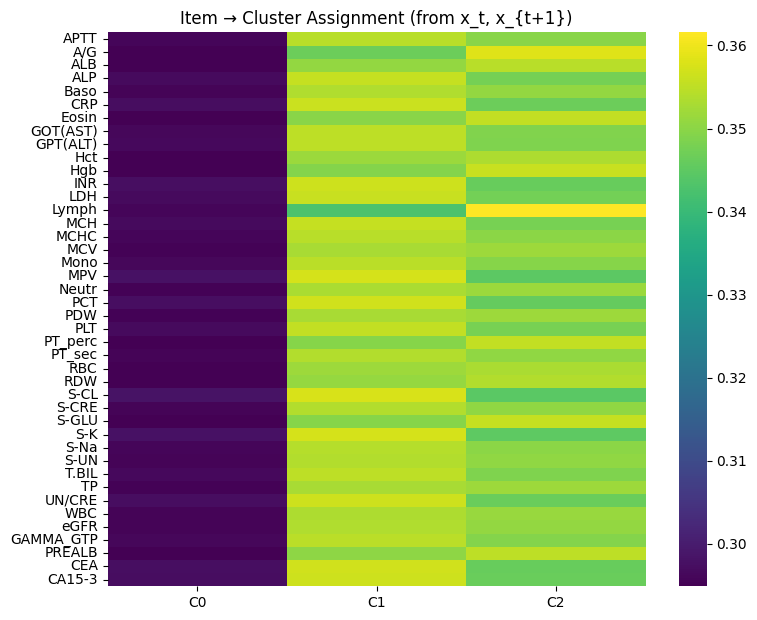

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Re-define F to ensure it's an integer, overriding any potential shadowing issues
F = len(feature_cols)

plt.figure(figsize=(8, max(4, F*0.15)))
sns.heatmap(
    S, cmap="viridis",
    yticklabels=feature_cols,
    xticklabels=[f"C{k}" for k in range(S.shape[1])]
)
plt.title("Item → Cluster Assignment (from x_t, x_{t+1})")
plt.tight_layout()
plt.show()